<a href="https://www.kaggle.com/code/sirfowahid/autism-preds?scriptVersionId=227375427" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

📌 Epoch 1/20, Loss: 0.8505, Accuracy: 0.6006
✅ Best Model Saved!
📌 Epoch 2/20, Loss: 0.5894, Accuracy: 0.6936
✅ Best Model Saved!
📌 Epoch 3/20, Loss: 0.5321, Accuracy: 0.7315
✅ Best Model Saved!
📌 Epoch 4/20, Loss: 0.4538, Accuracy: 0.7843
✅ Best Model Saved!
📌 Epoch 5/20, Loss: 0.3552, Accuracy: 0.8446
✅ Best Model Saved!
📌 Epoch 6/20, Loss: 0.2343, Accuracy: 0.9014
✅ Best Model Saved!
📌 Epoch 7/20, Loss: 0.1218, Accuracy: 0.9614
✅ Best Model Saved!
📌 Epoch 8/20, Loss: 0.0539, Accuracy: 0.9850
✅ Best Model Saved!
📌 Epoch 9/20, Loss: 0.0178, Accuracy: 0.9976
✅ Best Model Saved!
📌 Epoch 10/20, Loss: 0.0068, Accuracy: 1.0000
✅ Best Model Saved!
📌 Epoch 11/20, Loss: 0.0028, Accuracy: 1.0000
✅ Best Model Saved!
📌 Epoch 12/20, Loss: 0.0009, Accuracy: 1.0000
✅ Best Model Saved!
📌 Epoch 13/20, Loss: 0.0005, Accuracy: 1.0000
✅ Best Model Saved!
📌 Epoch 14/20, Loss: 0.0003, Accuracy: 1.0000
✅ Best Model Saved!
📌 Epoch 15/20, Loss: 0.0002, Accuracy: 1.0000
✅ Best Model Saved!
📌 Epoch 16/20, Loss

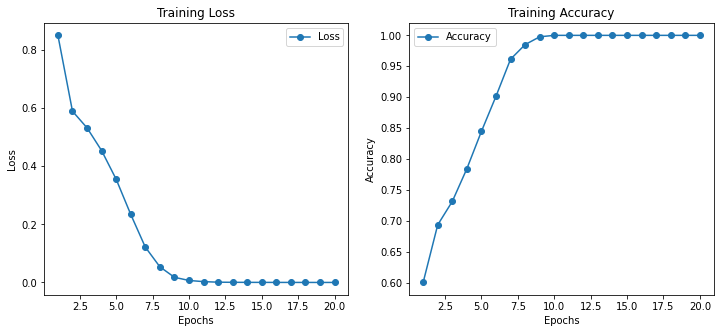

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjusted for 224x224 input
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (224 → 112)
        x = self.pool(self.relu(self.conv2(x)))  # (112 → 56)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Parameters
num_classes = 2  # Change based on dataset
model_path = "best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_path = "/kaggle/input/autistic-children-facial-data-set/train"
test_data_path = "/kaggle/input/autistic-children-facial-data-set/test"

def get_data_loaders(train_dir, test_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Updated to 224x224
        transforms.ToTensor()
    ])
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, train_dataset.classes

# Load Dataset
train_loader, test_loader, class_names = get_data_loaders(train_data_path, test_data_path)

# Check if Model Exists and Load it
model = CustomCNN(num_classes=num_classes).to(device)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("✅ Model Loaded! Skipping Training...")
    model.eval()
else:
    # Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training Loop
    best_loss = float('inf')
    train_losses = []
    train_accuracies = []
    
    for epoch in range(20):  # Adjust Epochs
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        avg_loss = running_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        
        print(f"📌 Epoch {epoch+1}/{20}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), model_path)
            print("✅ Best Model Saved!")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    
    plt.show()

# Function to Predict Single Image
def predict_image(image_path, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Updated to 224x224
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return class_names[predicted.item()]



In [2]:
# Example Usage
image_path = "/kaggle/input/autistic-children-facial-data-set/valid/non_autistic/02.jpg"  # Provide test image path
if os.path.exists(image_path):
    _, _, class_names = get_data_loaders(train_data_path, test_data_path)
    prediction = predict_image(image_path, model, class_names)
    print(f"Predicted Class: {prediction}")
else:
    print("Test image not found!")

Predicted Class: non_autistic
